# EuroBERT Regression

This notebook implements a EuroBERT-based regression model for automated essay scoring by combining prompts and essays into a unified text input.

## Key Findings

While EuroBERT achieved a classification-style accuracy of 46.26% by rounding its continuous predictions, it was not the main focus of our work, as we had already trained a BERT model with cross-attention mechanisms tailored to this task. The evaluation shows that EuroBERT performs significantly better than traditional models, particularly in handling class imbalances and capturing semantic nuances.

## Import and Setup

---

In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
)
device = torch.device(
    "mps"
    if torch.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

2025-06-18 09:14:56.077801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 09:14:56.085762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750230896.095868   10487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750230896.099033   10487 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750230896.107291   10487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda


# Data Import

---

In [2]:
train_df = pd.read_csv("../data/clean_train.csv")
test_df = pd.read_csv("../data/clean_test.csv")

In [3]:
train_df.shape

(9048, 14)

## Extracting the necessary features

---

In [4]:
train_df["band_score"] = train_df["band_score"] * 2
test_df["band_score"] = test_df["band_score"] * 2
train_df["band_score"] = train_df["band_score"].astype(int)
test_df["band_score"] = test_df["band_score"].astype(int)

# Subtract 8 from band_score to get the range 0-10 (this is needed for cuda)
train_df["band_score"] = train_df["band_score"] - 8
test_df["band_score"] = test_df["band_score"] - 8

In [5]:
# Splitting train into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")

Train shape: (7238, 14)
Val shape: (1810, 14)


## Oversampling

---

<Axes: xlabel='band_score'>

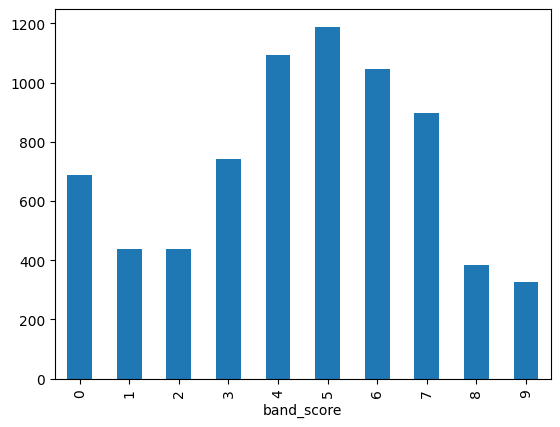

In [6]:
band_counts = train_df["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")

In [7]:
print("Before oversampling:")
print(f"Train shape: {train_df.shape}")
print(
    f"Train class distribution:\n{train_df['band_score'].value_counts().sort_index()}"
)


def random_oversample(df, target_column, random_state=42):
    """
    Randomly oversample minority classes to match the majority class
    """
    np.random.seed(random_state)

    # Get class counts
    class_counts = df["band_score"].value_counts()
    max_count = class_counts.max()

    oversampled_dfs = []

    for class_value in class_counts.index:
        class_df = df[df["band_score"] == class_value]
        current_count = len(class_df)

        if current_count < max_count:
            # Calculate how many more samples we need
            needed_samples = max_count - current_count

            # Randomly sample with replacement
            additional_samples = class_df.sample(
                n=needed_samples, replace=True, random_state=random_state
            )

            # Combine original and additional samples
            class_df_oversampled = pd.concat(
                [class_df, additional_samples], ignore_index=True
            )
        else:
            class_df_oversampled = class_df

        oversampled_dfs.append(class_df_oversampled)

    # Combine all classes
    result_df = pd.concat(oversampled_dfs, ignore_index=True)

    # Shuffle the dataset
    result_df = result_df.sample(frac=1, random_state=random_state).reset_index(
        drop=True
    )

    return result_df


# Apply oversampling to training data only
train_df = random_oversample(train_df, "band_score", random_state=42)

print("\nAfter oversampling:")
print(f"Train shape: {train_df.shape}")
print(
    f"Train class distribution:\n{train_df['band_score'].value_counts().sort_index()}"
)
print(f"Val shape: {val_df.shape}")

Before oversampling:
Train shape: (7238, 14)
Train class distribution:
band_score
0     689
1     438
2     437
3     741
4    1093
5    1189
6    1046
7     896
8     384
9     325
Name: count, dtype: int64

After oversampling:
Train shape: (11890, 14)
Train class distribution:
band_score
0    1189
1    1189
2    1189
3    1189
4    1189
5    1189
6    1189
7    1189
8    1189
9    1189
Name: count, dtype: int64
Val shape: (1810, 14)


<Axes: xlabel='band_score'>

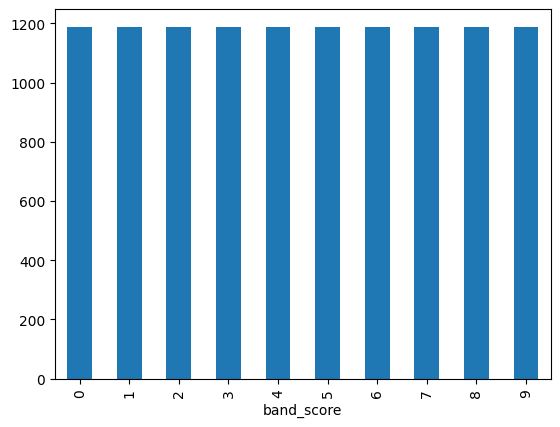

In [8]:
band_counts = train_df["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")

In [9]:
train_df["text"] = train_df["prompt"] + " [SEP] " + train_df["essay"]
test_df["text"] = test_df["prompt"] + " [SEP] " + test_df["essay"]
val_df["text"] = val_df["prompt"] + " [SEP] " + val_df["essay"]

## Model and Training

---

In [10]:
model_name = "EuroBERT/EuroBERT-210m"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# num_labels=1 because of regression
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=1, problem_type="regression", trust_remote_code=True
)

Some weights of EuroBertForSequenceClassification were not initialized from the model checkpoint at EuroBERT/EuroBERT-210m and are newly initialized: ['classifier.bias', 'classifier.weight', 'dense.bias', 'dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import torch


class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df["text"].tolist()
        # Wichtig: Die Scores müssen numerisch sein
        self.labels = df["band_score"].astype(float).tolist()
        self.tokenizer = tokenizer
        self.max_len = 512  # Maximale Länge für RoBERTa

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokeniziere den Text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            # Die Labels müssen als Float-Tensor übergeben werden
            "labels": torch.tensor(label, dtype=torch.float),
        }


train_dataset = EssayDataset(train_df, tokenizer)
test_dataset = EssayDataset(test_df, tokenizer)

## Metrics

---

In [12]:
def compute_metrics(p):
    preds = p.predictions.flatten()
    labels = p.label_ids.flatten()
    mse = mean_squared_error(labels, preds)
    mae = mean_absolute_error(labels, preds)
    return {
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
    }


# Definiere die Argumente für das Training
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mean_absolute_error",
    greater_is_better=False,
)

# Erstelle den Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Starte das Training! 🚀
trainer.train()

# Speichere das finale, fein-trainierte Modell und den Tokenizer
trainer.save_model("../models/eurobert_v1")
tokenizer.save_pretrained("../tokenizer/eurotoke_v1")

Epoch,Training Loss,Validation Loss,Mean Squared Error,Mean Absolute Error
1,2.962500,2.669069,2.669069,1.301041
2,0.918600,1.817126,1.817126,0.979285
3,0.564700,1.624493,1.624493,0.865985


('../tokenizer/eurotoke_v1/tokenizer_config.json',
 '../tokenizer/eurotoke_v1/special_tokens_map.json',
 '../tokenizer/eurotoke_v1/tokenizer.json')

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def confusion_matrix_plot(cm, num_classes):
    """
    Plot a confusion matrix.

    Args:
        cm (np.ndarray): The confusion matrix.
        num_classes (int): The number of classes.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[str(i) for i in range(num_classes)],
        yticklabels=[str(i) for i in range(num_classes)],
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

def evaluate_regression_as_classification(model, data_loader, device, max_length=512):
    """
    Evaluate a regression model by converting predictions to integers
    and treating them as classification labels.

    Args:
        model: The model to evaluate.
        data_loader: The data loader to use for evaluation.
        device: The device to run the model on.
        max_length: The maximum length of the input sequence.

    Returns:
        tuple: (accuracy, classification_report, confusion_matrix)
    """
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Get regression predictions (continuous values)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.squeeze()  # Extract logits and remove extra dimensions

            # Convert continuous predictions to integers (round to nearest integer)
            preds_int = torch.round(preds).int()

            # Convert actual scores to integers as well
            labels_int = torch.round(labels).int()

            # Convert to CPU and extend lists
            predictions.extend(preds_int.cpu().tolist())
            actual_labels.extend(labels_int.cpu().tolist())

    # Calculate classification metrics
    accuracy = accuracy_score(actual_labels, predictions)
    class_report = classification_report(actual_labels, predictions)
    conf_matrix = confusion_matrix(actual_labels, predictions)

    return accuracy, class_report, conf_matrix

Accuracy: 0.46255506607929514

 Report:
              precision    recall  f1-score   support

           0       0.74      0.43      0.55        46
           1       0.42      0.61      0.50        31
           2       0.36      0.60      0.45        20
           3       0.63      0.48      0.54        61
           4       0.45      0.45      0.45        67
           5       0.40      0.43      0.41        81
           6       0.38      0.45      0.41        65
           7       0.43      0.39      0.41        46
           8       0.48      0.52      0.50        21
           9       0.88      0.44      0.58        16

    accuracy                           0.46       454
   macro avg       0.52      0.48      0.48       454
weighted avg       0.49      0.46      0.47       454



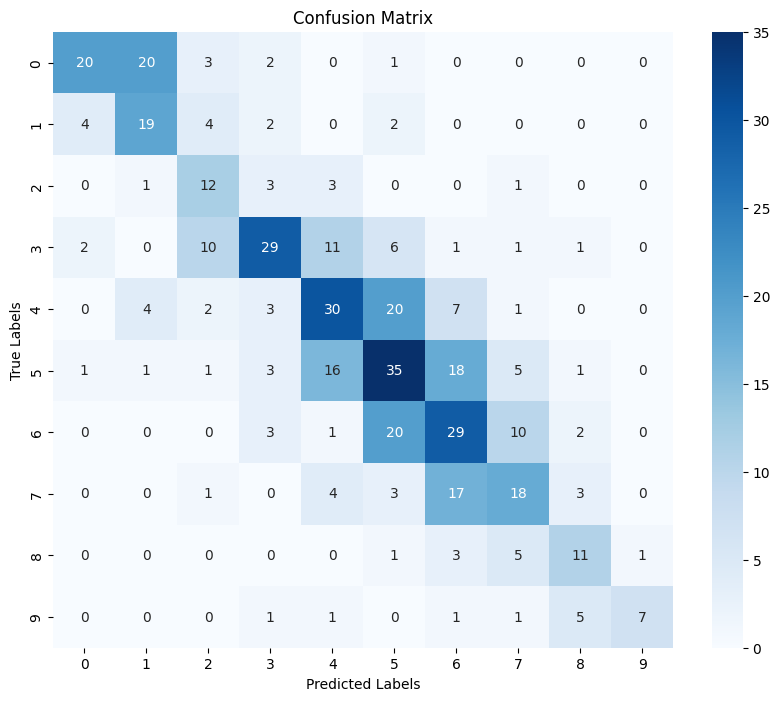

In [14]:
from torch.utils.data import DataLoader

test_dataset = EssayDataset(test_df, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
accuracy, report, cm = evaluate_regression_as_classification(
    model, test_dataloader, device
)

print(f"Accuracy: {accuracy}")
print("\n Report:")
print(report)

confusion_matrix_plot(cm, 10)

### [`Click here to go back to the Homepage`](../Homepage.md)